 Copyright ...
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
      http://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
 

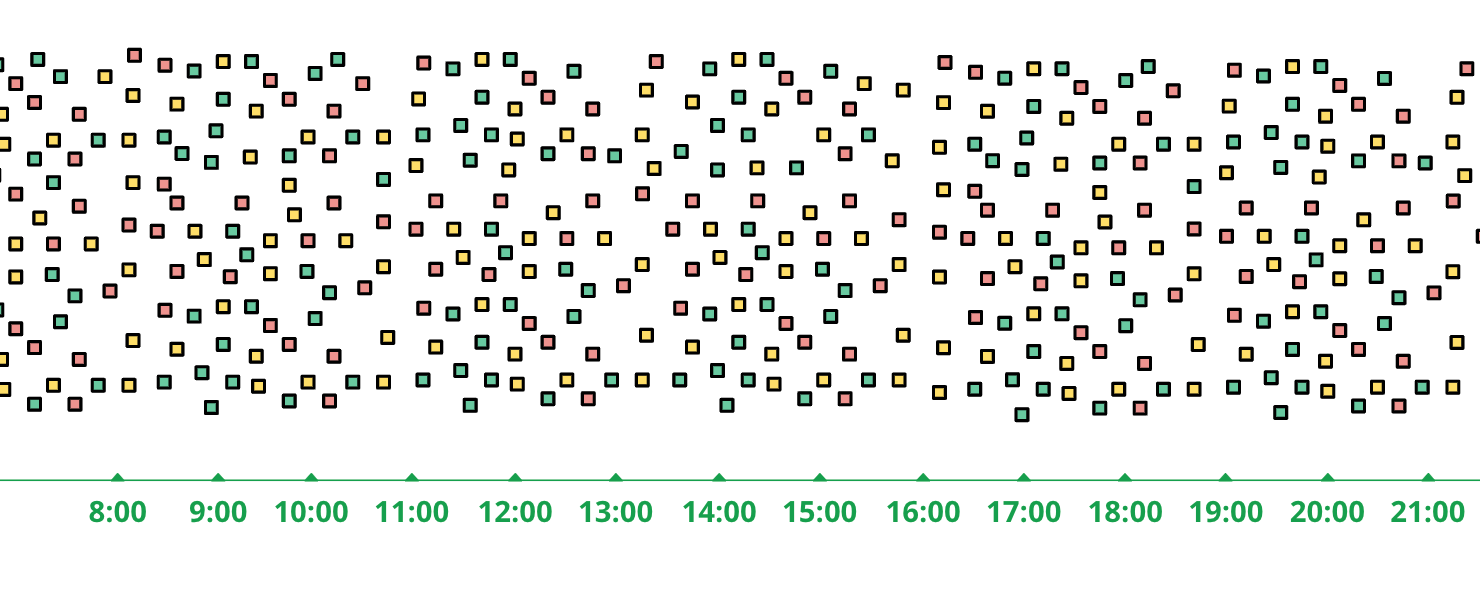

# OVERVIEW

One of the key strengths of Apache Beam's model is its ability to deal with the complexities of accurately processing unbounded data collections. The primitives that are used, Windowing , Triggers and their interactions with model concepts such as watermarks can however lead to a steep learning curve. In this codelab we will aim to walk through these concepts via a practical framework.

The first few examples will cover basics areas, with the complexity increasing as we work through to watermarks and triggers.

## Prerequisites

Please watch the earlier webinars on Beam and the basics of windows before this.

## Outline

* Timestamps and sources ( Basic )
 * There is always a window! 
 * Accessing Beam's time metadata
 * Source attached timestamps
 * What timestamps could be associated with an element?
 * Windows assignment
* Accurate stream processing ( Intermediate / Advanced )
 * Event time, and why it matters
 * Watermarks, on-time and late data...
 * Early results, and so we get to triggers
* Merging windows

## Setup

Run these cells to setup.

In [ ]:
!pip install apache_beam==2.28.0 --quiet

     |████████████████████████████████| 9.0MB 10.2MB/s 
     |████████████████████████████████| 153kB 39.2MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 2.2MB 34.7MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 829kB 39.7MB/s 
     |████████████████████████████████| 17.7MB 202kB/s 
     |████████████████████████████████| 112kB 49.4MB/s 
ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [ ]:
# Lets set up our imports 
import argparse
import datetime
import time
from typing import Dict, Text, Any, Tuple, List, Iterable


import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.typehints.typehints import Optional
from apache_beam.options.pipeline_options import StandardOptions
from apache_beam.testing.test_pipeline import TestPipeline
from apache_beam.testing.test_stream import TestStream

#TIMESTAMPS AND SOURCES



## There is always a window!

For this example and the rest of this codelab we will make use of some imaginary stock ticks for a stock with symbol 'A'. To keep things simple we will use Count as our aggregation transform.

The result of the count below will be 6.

In [ ]:
# In this cell we are going to run a simple pipeline that computes the Count of
# a list of values, which have the key 'A'. 

our_values = [('A', 1.05), ('A', 1.02), ('A', 1.03), ('A', 1.04), ('A', 1.06), ('A', 1.07)]

with beam.Pipeline() as p:
  _ = (p | beam.Create(our_values) 
         | beam.transforms.combiners.Count.PerKey()
         | beam.Map(lambda x : f'Count is {x[1]}')
         | beam.Map(print)
  )

Count is 6


## Accessing Beam's time metadata

When the previous pipeline ran, all the values had in fact been assigned to a window, the Global Window. 
 
In order to see this directly we will make use of some tools to introspect the metadata which exists with every data element that is read from a source.

In [ ]:
our_values = [('A', 1.05), ('A', 1.02), ('A', 1.03), ('A', 1.04), ('A', 1.06), ('A', 1.07)]


# This DoFn makes use of TimestampParam to access the elements timestamp
# We also make use of WindowParam to access the window that the element belongs to 
class GetElementTimestamp(beam.DoFn):
  def __init__(self, print_pane_info: bool = False):
    self.print_pane_info = print_pane_info
  
  def process(self, element: Any, 
              timestamp=beam.DoFn.TimestampParam,
              window=beam.DoFn.WindowParam,
              pane_info=beam.DoFn.PaneInfoParam
                )-> Iterable[Tuple[str,str]]:

    timestamp_str = ""
    try:
        timestamp_str = timestamp.to_utc_datetime()
    except:
        timestamp_str = timestamp
    
    window_str = ""

    if window == beam.window.GlobalWindow():
      window_str = "The Global Window"
    else: 
      window_str = f'Window ends at {window.max_timestamp().to_utc_datetime()}'

    if self.print_pane_info:
      yield (window_str , f'The value : {element} has timestamp {timestamp_str} with Pane {pane_info}')
    else: 
      yield (str({window_str}), f'The value : {element} has timestamp {timestamp_str}')

class PrettyPrint(beam.PTransform):
  """ Pretty print all values in a pcollection sorted on the first value in the tuple """
  def expand(self, pcoll):
    return ( pcoll | beam.combiners.ToList().without_defaults() 
                   | beam.Map(lambda x : sorted(x, key=lambda tup: tup[0]))
                   | beam.Map(lambda x : print(*x, sep = "\n") )
    )

In [ ]:
our_values = [('A', 1.05), ('A', 1.02), ('A', 1.03), ('A', 1.04), ('A', 1.06), ('A', 1.07)]

with beam.Pipeline() as p:
  _ = (p | beam.Create(our_values) 
         | beam.ParDo(GetElementTimestamp())
         | PrettyPrint()
  )

("{'The Global Window'}", "The value : ('A', 1.05) has timestamp Timestamp(-9223372036854.775000)")
("{'The Global Window'}", "The value : ('A', 1.02) has timestamp Timestamp(-9223372036854.775000)")
("{'The Global Window'}", "The value : ('A', 1.03) has timestamp Timestamp(-9223372036854.775000)")
("{'The Global Window'}", "The value : ('A', 1.04) has timestamp Timestamp(-9223372036854.775000)")
("{'The Global Window'}", "The value : ('A', 1.06) has timestamp Timestamp(-9223372036854.775000)")
("{'The Global Window'}", "The value : ('A', 1.07) has timestamp Timestamp(-9223372036854.775000)")


## Source attached timestamps

All source transforms will produce output elements which have been tagged with timestamp metadata. In the absence of any timestamp information all the data is assigned 'negative infinity' as a value. Negative infinity being defined as the beginning of the `GlobalWindow`. The cell below outputs the start and end point of the global window in the beam model.

In [ ]:
# Lets look at the GlobalWindow's start and end attributes
global_window = beam.transforms.window.GlobalWindow()
print(f'Global window start {global_window.start} end {global_window.end}')

Global window start Timestamp(-9223372036854.775000) end Timestamp(9223371950454.775000)


## What timestamps could be associated with an element? 

### Timestamps based on Processing time

Sources are free to attach timestamps to elements other than 'negative infinity'. By default for example, `PubSubIO` attaches the time that an element is published to the PubSub topic. However with PubSub and many other sources, you can provide extra information to make use of Event time rather than processing time.

### Timestamps based on Event time
Many sources, for example Google cloud `PubSubIO` or `KafkaIO` have the ability to make use of metadata about the element to set timestamp. With `PubSubIO` this is done via `timestampid` and with `KafkaIO` this is done via withTimestampPolicyFactory. ***(Note `KafkaIO` is accessible in Python via the xlang transform)***. This allows the Beam pipeline to aggregate data based on the actual time that the event happened rather than processing time


For our examples we can simulate this using by wrapping our example elements in `beam.window.TimestampedValue`. This takes a `value: Any` along with a `timestamp:time`. The Transforms `Create` can make use of this value to assign the correct Event time to the element.

The cell below will create a set of data points with the following timestamps. Note 10:00:01 has two values and that there is a gap between 10:00:03 and 10:00:08. 

| Time | Value |
| ---  |  ---  |
|10:00:00 |1.05|
|**10:00:01** |1.02|
|**10:00:01** |1.03|
|10:00:02 |1.04|
|10:00:03 |1.06|
|**10:00:08** |1.07|





In [ ]:
format = '%Y/%m/%d %H:%M:%S'
start = time.mktime(time.strptime('2000/01/01 10:00:00', format))

our_values = [('A', 1.05), ('A', 1.02), ('A', 1.04), ('A', 1.06)]

# This will create a Tuple of key, value, timestamp_as_date_str
our_values_with_timestamps = [beam.window.TimestampedValue(k, ( int(start + i))) for k, i in zip( our_values, range(0,len(our_values)))]
# Next we will add a value which is several seconds ahead of the last value shown above, this will be used later
our_values_with_timestamps.append(beam.window.TimestampedValue(('A',1.03), int(start+1)))
our_values_with_timestamps.append(beam.window.TimestampedValue(('A',1.07), int(start+8)))

our_values_with_timestamps.sort(key=lambda x:x.timestamp)

for i in our_values_with_timestamps:
  print(f' Value {i.value} has event timestamp {i.timestamp.to_utc_datetime()}')

 Value ('A', 1.05) has event timestamp 2000-01-01 10:00:00
 Value ('A', 1.02) has event timestamp 2000-01-01 10:00:01
 Value ('A', 1.03) has event timestamp 2000-01-01 10:00:01
 Value ('A', 1.04) has event timestamp 2000-01-01 10:00:02
 Value ('A', 1.06) has event timestamp 2000-01-01 10:00:03
 Value ('A', 1.07) has event timestamp 2000-01-01 10:00:08


##Our first time window, Fixed Windows

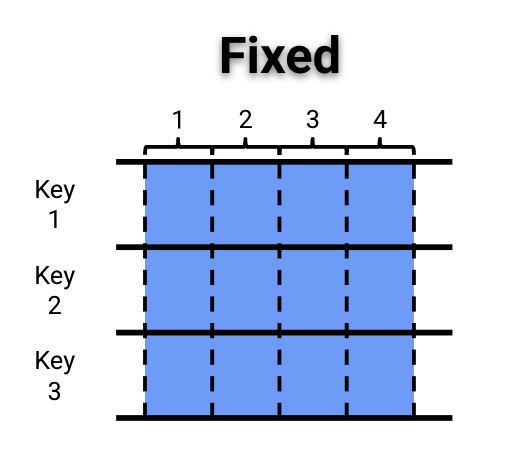




In the following steps we will read from our newly created source which uses `TimestampedValue` . We will then create a FixedWindow of 1 sec and look at our Metadata again.


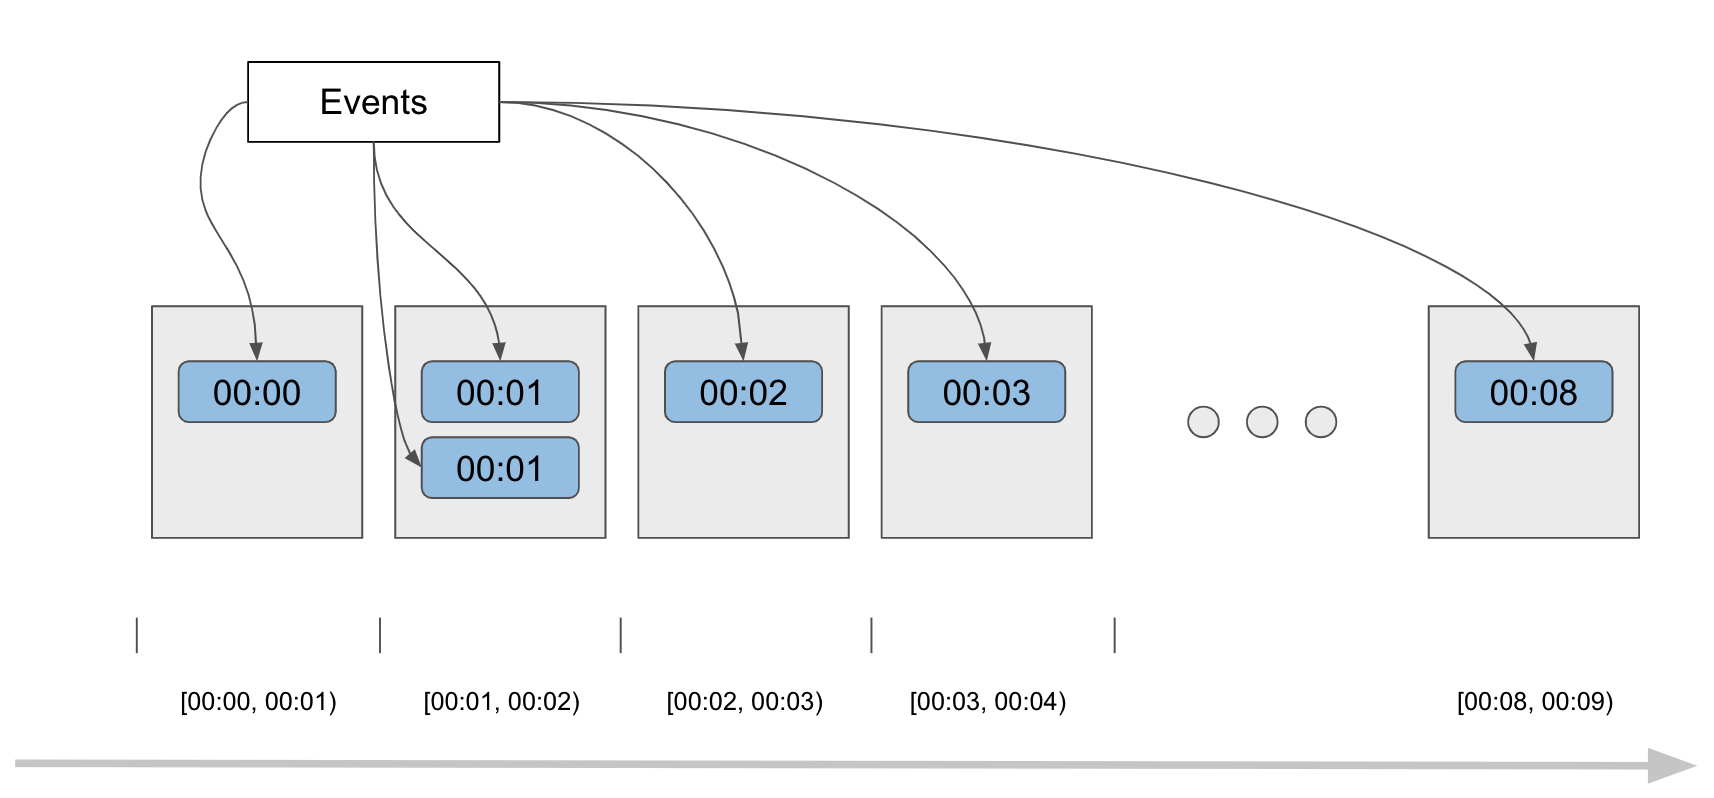

In [ ]:
with beam.Pipeline() as p:
  _ = (p| beam.Create(our_values_with_timestamps)
        # | beam.Map(lambda x : x) # Work around for typing issue
        | beam.WindowInto(beam.window.FixedWindows(1))
        | beam.ParDo(GetElementTimestamp())
        | PrettyPrint()
  )

("{'Window ends at 2000-01-01 10:00:00.999999'}", "The value : ('A', 1.05) has timestamp 2000-01-01 10:00:00")
("{'Window ends at 2000-01-01 10:00:01.999999'}", "The value : ('A', 1.02) has timestamp 2000-01-01 10:00:01")
("{'Window ends at 2000-01-01 10:00:01.999999'}", "The value : ('A', 1.03) has timestamp 2000-01-01 10:00:01")
("{'Window ends at 2000-01-01 10:00:02.999999'}", "The value : ('A', 1.04) has timestamp 2000-01-01 10:00:02")
("{'Window ends at 2000-01-01 10:00:03.999999'}", "The value : ('A', 1.06) has timestamp 2000-01-01 10:00:03")
("{'Window ends at 2000-01-01 10:00:08.999999'}", "The value : ('A', 1.07) has timestamp 2000-01-01 10:00:08")


Important to note the windowing does not actually take place until GroupByKey or Combine operation. The data is merely tagged.

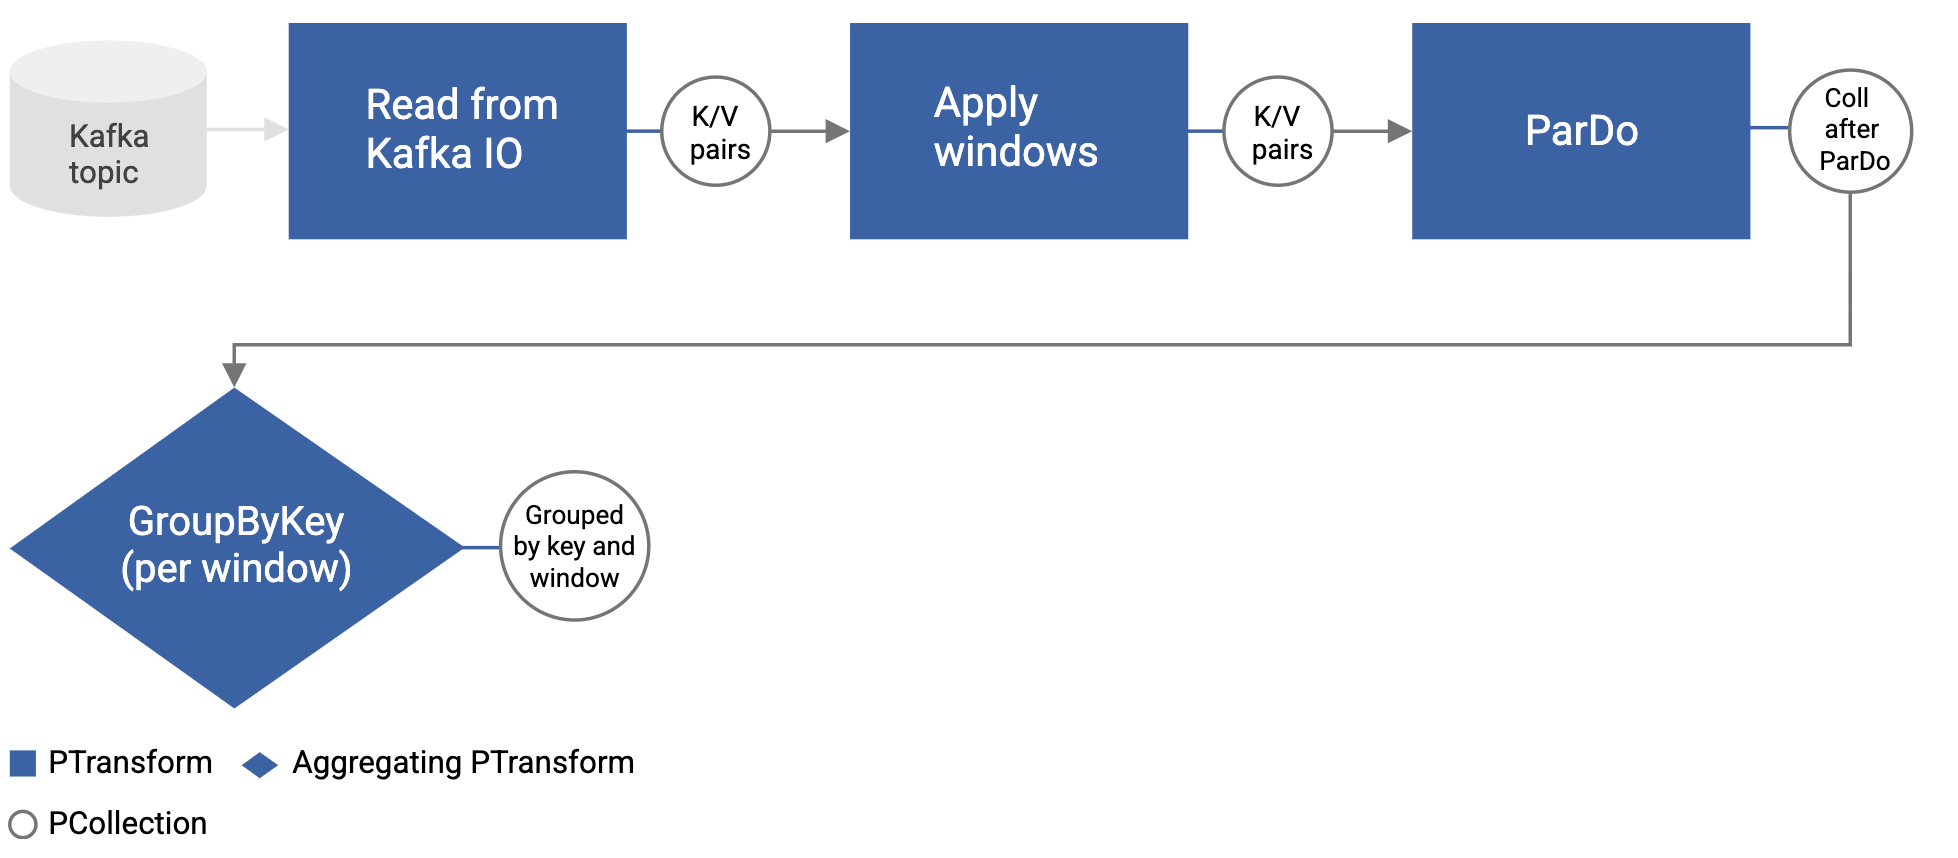

Our previous count operation will now return one value per key per sec.
 
Take note of the final window, which has a starting value of 8, notice there is a 3 sec gap between it and the last value. This is because no window will be produced if no data element is present.

In [ ]:
with beam.Pipeline() as p:
  _ = (p| beam.Create(our_values_with_timestamps)
         | beam.Map(lambda x : x) # Work around for typing issue
         | beam.WindowInto(beam.window.FixedWindows(1))
         | beam.combiners.Count.PerKey()
         | beam.Map(lambda x : f'Count is {x[1]}')
         | beam.ParDo(GetElementTimestamp())
         | PrettyPrint()
  )

("{'Window ends at 2000-01-01 10:00:00.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:00.999000')
("{'Window ends at 2000-01-01 10:00:01.999999'}", 'The value : Count is 2 has timestamp 2000-01-01 10:00:01.999000')
("{'Window ends at 2000-01-01 10:00:02.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:02.999000')
("{'Window ends at 2000-01-01 10:00:03.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:03.999000')
("{'Window ends at 2000-01-01 10:00:08.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:08.999000')


Source data:

| Time | Value |
| ---  |  ---  |
|10:00:00 |1.05|
|**10:00:01** |1.02|
|**10:00:01** |1.03|
|10:00:02 |1.04|
|10:00:03 |1.06|
|**10:00:08** |1.07|

Count data:

| Window - Start | Window - End | Value |
| ---  |  ---  | ---  |
| 10:00:00 | 10:00:00.999999 | 1 |
| 10:00:01 | 10:00:01.999999 | 2 |
| 10:00:02 | 10:00:02.999999 | 1 |
| 10:00:03 | 10:00:03.999999 | 1 |
| 10:00:08 | 10:00:08.999999 | 1 |

#ACCURATE STREAM PROCESSING




## Event time, and why it matters

In the bounded pipeline example above, all the data we needed to compute our values is available 'all at once'. As long as we assign the TimestampedValue we know that every element will be assigned to its correct window. But what happens if our source is a streaming source, like PubSub, where data upstream can be inserted into the topic out of sequence or late? 
 
The diagram shows the event stream observation of a system. One of the three events with the same event timestamp (8:00) arrived 12 hours late, such things happen when processing real world data (e.g. person is offline for several hours) .




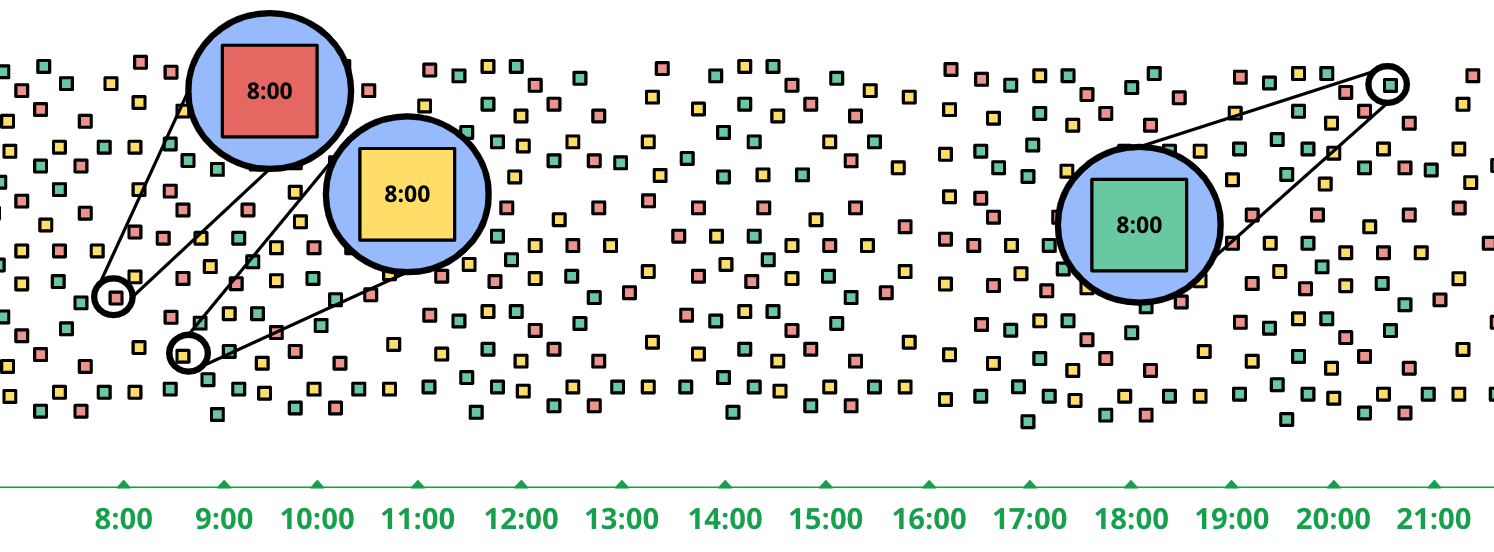

##Watermarks, on time and late data...



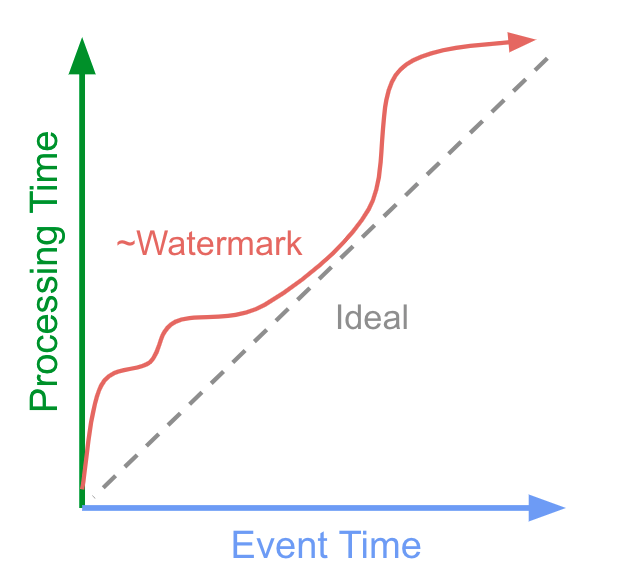

**Watermark Intuition** 

A watermark is our estimation of the data we will see in the future!

Apache Beam documentation:

"*In any data processing system, there is a certain amount of lag between the time a data event occurs (the “event time”, determined by the timestamp on the data element itself) and the time the actual data element gets processed at any stage in your pipeline (the “processing time”, determined by the clock on the system processing the element). In addition, there are no guarantees that data events will appear in your pipeline in the same order that they were generated.*"

...

"*Beam tracks a watermark, which is the system’s notion of when all data in a certain window can be expected to have arrived in the pipeline. Once the watermark progresses past the end of a window, any further element that arrives with a timestamp in that window is considered late data.*"

In Beam Watermark of a streaming step is a monotonically increasing timestamp that tracks the minimum timestamp upstream of this step.
For upstream Beam steps, this is tracked perfectly.
For sources, the watermark is *estimated*

In a pipeline every step will have an input watermark which is determined by steps upstream.

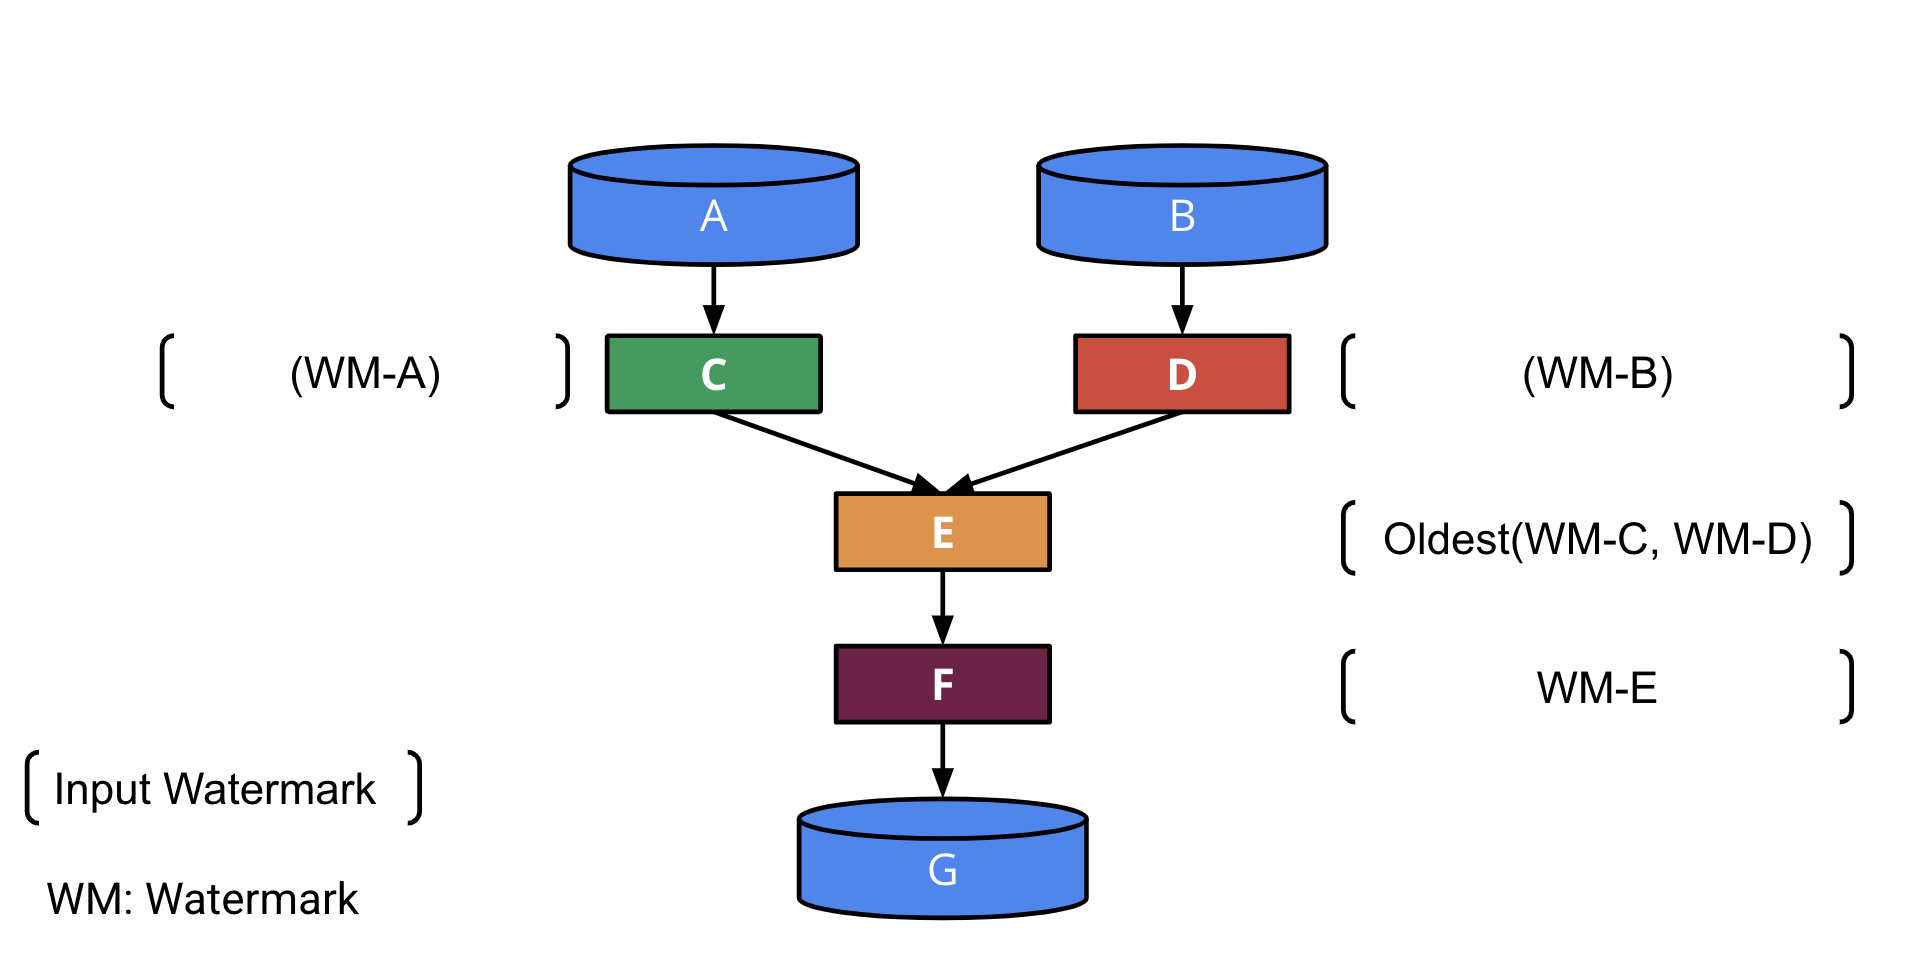

### Using Teststream

To illustrate this with our example, we will make use the Apache Beam testing utility class to simulate an unbounded source of data. 

Below we will reproduce our data as before with elements being added to the test stream and the watermark for the stream moving forward as expected.

NOTE: Initially we are NOT using `TimestampedValue`



In [ ]:
format = '%Y/%m/%d %H:%M:%S'
start = time.mktime(time.strptime('2000/01/01 10:00:00', format))

test_stream = TestStream()

# Watermark is set to 10:00:00
test_stream.advance_watermark_to(start)
# lets add some values
test_stream.add_elements([('A', 1.05)]) # <-- We add an element
test_stream.advance_watermark_to(start+1) # <-- We advance the watermark
# Watermark is set to 10:00:01
# We repeat the process until we have all the values in our unbounded simulation 
test_stream.add_elements([('A', 1.02)])
test_stream.add_elements([('A', 1.03)])
test_stream.advance_watermark_to(start+2)
# Watermark is set to 10:00:02
test_stream.add_elements([('A', 1.04)])
test_stream.advance_watermark_to(start+3)
# Watermark is set to 10:00:03
test_stream.add_elements([('A', 1.06)])
test_stream.advance_watermark_to(start+8)
# Watermark is set to 10:00:08
test_stream.add_elements([('A', 1.07)])

test_stream.advance_watermark_to_infinity()

with beam.Pipeline() as p:
  _ = (p| test_stream
        | beam.Map(lambda x : x) # Work around for typing issue
        | beam.WindowInto(beam.window.FixedWindows(1))
        | beam.ParDo(GetElementTimestamp())
        | PrettyPrint()
  )

("{'Window ends at 2000-01-01 10:00:00.999999'}", "The value : ('A', 1.05) has timestamp 2000-01-01 10:00:00")
("{'Window ends at 2000-01-01 10:00:01.999999'}", "The value : ('A', 1.02) has timestamp 2000-01-01 10:00:01")
("{'Window ends at 2000-01-01 10:00:01.999999'}", "The value : ('A', 1.03) has timestamp 2000-01-01 10:00:01")
("{'Window ends at 2000-01-01 10:00:02.999999'}", "The value : ('A', 1.04) has timestamp 2000-01-01 10:00:02")
("{'Window ends at 2000-01-01 10:00:03.999999'}", "The value : ('A', 1.06) has timestamp 2000-01-01 10:00:03")
("{'Window ends at 2000-01-01 10:00:08.999999'}", "The value : ('A', 1.07) has timestamp 2000-01-01 10:00:08")


| Time | Value |
| ---  |  ---  |
|10:00:00 |1.05|
|**10:00:01** |1.02|
|**10:00:01** |1.03|
|10:00:02 |1.04|
|10:00:03 |1.06|
|**10:00:08** |1.07|

Even though we did not use TimestampedValue all the elements have been assigned the correct timestamp. This is because we carefully built the TestStream adding the elements and moving the watermark in the exact same sequence as the Event time. This would be highly unusual with a real source system! 



In [ ]:
# We will be reusing this code during several examples, lets create a function to produce our pipeline for us.

def create_pipeline(test_stream:TestStream, 
                    print_pane_info: bool = False,
                    ):
  options = StandardOptions(streaming=True)

  with TestPipeline(options=options) as p:
    _ = (p | test_stream 
           | beam.Map(lambda x : x) # Work around for typing issue
           | beam.WindowInto(beam.window.FixedWindows(1))
           | beam.combiners.Count.PerKey()
           | beam.Map(lambda x : f'Count is {x[1]}')
           | "Output Window" >> beam.ParDo(GetElementTimestamp(print_pane_info=print_pane_info))
           | "Print count" >> PrettyPrint()
    )

In [ ]:
# We will first add our examples to the test stream with different processing time values.
# We will advance the watermark to 1 sec before our start time 

format = '%Y/%m/%d %H:%M:%S'
start = time.mktime(time.strptime('2000/01/01 10:00:00', format))

test_stream = TestStream()
test_stream.advance_watermark_to(start)
test_stream.advance_processing_time(start)

# lets add the values
test_stream.add_elements([('A', 1.05 )])
test_stream.advance_watermark_to(start+1)
test_stream.add_elements([('A', 1.02)])
test_stream.add_elements([('A', 1.03)])
test_stream.advance_watermark_to(start+2)
test_stream.add_elements([('A', 1.04)])
test_stream.advance_watermark_to(start+3)
test_stream.add_elements([('A', 1.06)])
test_stream.advance_watermark_to(start+4)
test_stream.advance_watermark_to(start+8)
test_stream.add_elements([('A', 1.07)])


test_stream.advance_watermark_to_infinity()

create_pipeline(test_stream, print_pane_info=False)

("{'Window ends at 2000-01-01 10:00:00.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:00.999999')
("{'Window ends at 2000-01-01 10:00:01.999999'}", 'The value : Count is 2 has timestamp 2000-01-01 10:00:01.999999')
("{'Window ends at 2000-01-01 10:00:02.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:02.999999')
("{'Window ends at 2000-01-01 10:00:03.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:03.999999')
("{'Window ends at 2000-01-01 10:00:08.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:08.999999')


As expected, the results from the count are also going to be correct.

| Window - Start | Window - End | Value |
| ---  |  ---  | ---  |
| 10:00:00 | 10:00:00.999999 | 1 |
| 10:00:01 | 10:00:01.999999 | 2 |
| 10:00:02 | 10:00:02.999999 | 1 |
| 10:00:03 | 10:00:03.999999 | 1 |
| 10:00:08 | 10:00:08.999999 | 1 |

But what if we did have a late date or data skew? Similar to the image below?

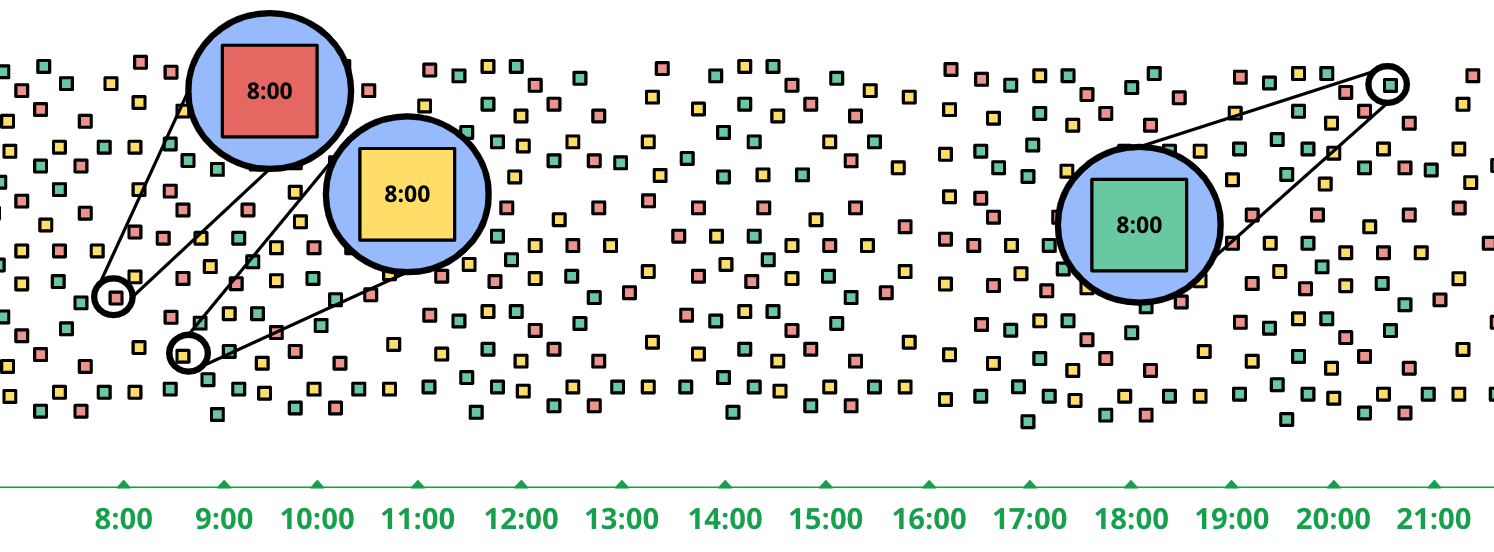

Lets now change the order in which data arrives into our `TestStream` system, with the value of 1.09 arriving late.

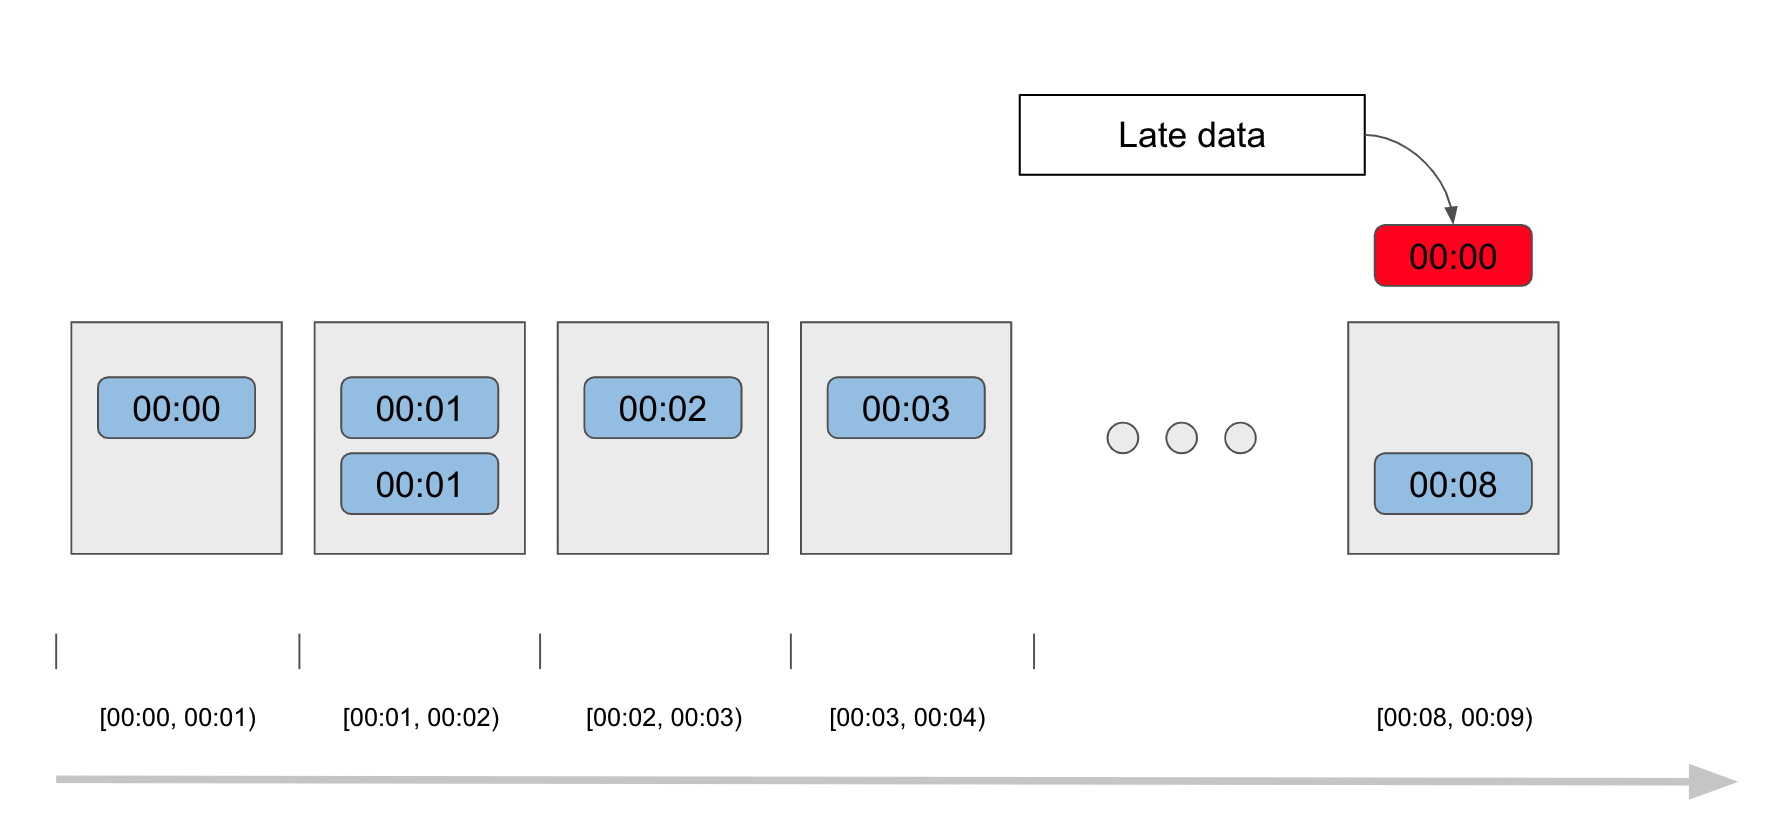

In [ ]:
from apache_beam.options.pipeline_options import StandardOptions
from apache_beam.testing.test_pipeline import TestPipeline
from apache_beam.testing.test_stream import TestStream

# Teststream with late data

format = '%Y/%m/%d %H:%M:%S'
start = time.mktime(time.strptime('2000/01/01 10:00:00', format))

test_stream = TestStream()
test_stream.advance_watermark_to(start)
test_stream.advance_processing_time(start)
# lets add the values
test_stream.add_elements([('A', 1.05 )])
test_stream.advance_watermark_to(start+1)
test_stream.add_elements([('A', 1.02)])
test_stream.add_elements([('A', 1.03)])
test_stream.advance_watermark_to(start+2)
test_stream.add_elements([('A', 1.04)])
test_stream.advance_watermark_to(start+3)
test_stream.add_elements([('A', 1.06)])

test_stream.advance_watermark_to(start+8)
test_stream.add_elements([('A', 1.07)])
test_stream.add_elements([('A', 1.09)]) # <-- Data arives late

test_stream.advance_watermark_to_infinity()

create_pipeline(test_stream, print_pane_info=False)

("{'Window ends at 2000-01-01 10:00:00.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:00.999999')
("{'Window ends at 2000-01-01 10:00:01.999999'}", 'The value : Count is 2 has timestamp 2000-01-01 10:00:01.999999')
("{'Window ends at 2000-01-01 10:00:02.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:02.999999')
("{'Window ends at 2000-01-01 10:00:03.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:03.999999')
("{'Window ends at 2000-01-01 10:00:08.999999'}", 'The value : Count is 2 has timestamp 2000-01-01 10:00:08.999999')


As we can see the values of the Count are now incorrect:

| Window - Start | Window - End | Value |
| :---:  |  :---:  | :---:  |
| 10:00:00 | 10:00:00.999999 | 1 |
| 10:00:01 | 10:00:01.999999 | 2 |
| 10:00:02 | 10:00:02.999999 | 1 |
| 10:00:03 | 10:00:03.999999 | 1 |
| **10:00:08** | **10:00:08.999999** | **2 Incorrect!** | 

The value of 1.09 has been assigned to window with end timestamp 2000-01-01 10:00:08.999999. Which corresponds to window [10:00:08, 10:00:09). 

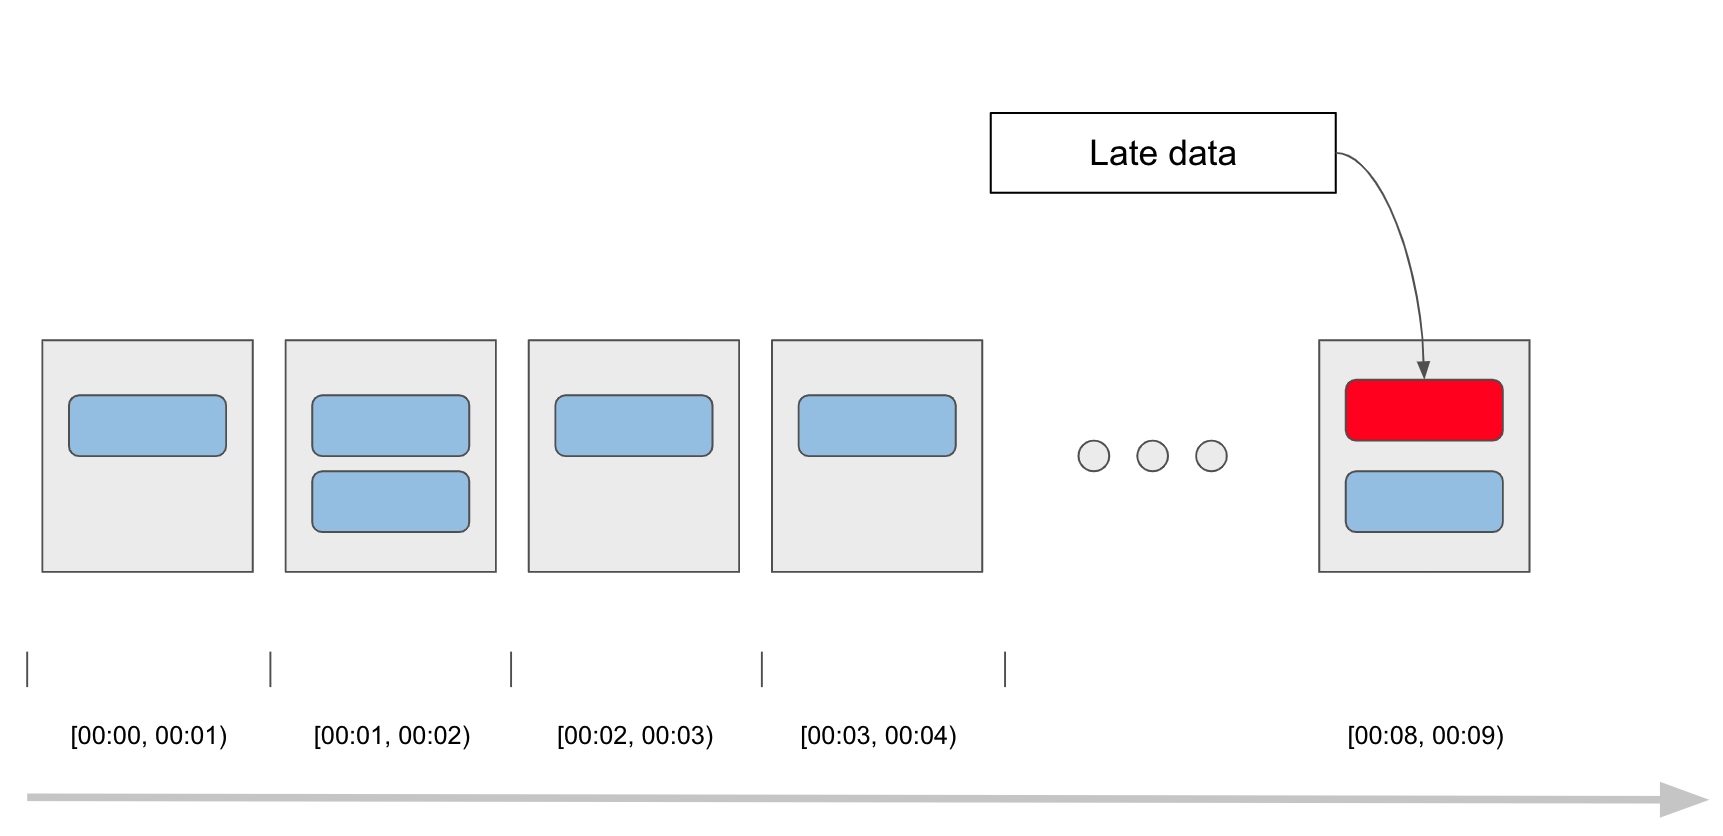

In this case our unbounded test stream simulation was simulating the elements arrival as they arrived into the system, without looking at the events actual timestamp. So with the absence of any event timestamp information the system added the element to the window that corresponds to the processing time when the element was added to the `TestStream`.

When reading from unbounced sources such as PubSubIO and KafkaIO, we have the ability to ensure that the event time is used for the element rather than the processing time. We can simulate that using TestStream by passing in **`TimestampedValue`**.

We will add this to our previous example and run the sample again. The default behaviour of Beam will be for late data to be dropped and not be included in the aggregations. We will explore other treatments of late data later on.




In [ ]:
def create_late_data_stream():

  format = '%Y/%m/%d %H:%M:%S'
  start = time.mktime(time.strptime('2000/01/01 10:00:00', format))

  test_stream = TestStream()
  test_stream.advance_watermark_to(start)
  test_stream.advance_processing_time(start)

  # lets add the values
  test_stream.add_elements([beam.window.TimestampedValue(('A', 1.05), start)])
  test_stream.advance_watermark_to(start+1)
  test_stream.advance_processing_time(start+1)
  test_stream.add_elements([beam.window.TimestampedValue(('A', 1.02), start+1)])
  test_stream.add_elements([beam.window.TimestampedValue(('A', 1.03), start+1)])
  test_stream.advance_watermark_to(start+2)
  test_stream.advance_processing_time(start+2)
  test_stream.add_elements([beam.window.TimestampedValue(('A', 1.04), start+2)])
  test_stream.advance_watermark_to(start+3)
  test_stream.advance_processing_time(start+3)
  test_stream.add_elements([beam.window.TimestampedValue(('A', 1.06), start+3)])

  test_stream.advance_watermark_to(start+8)
  test_stream.advance_processing_time(start+8)
  test_stream.add_elements([beam.window.TimestampedValue(('A', 1.07), start+8)])
  
  test_stream.add_elements([beam.window.TimestampedValue(('A', 1.09), start)]) # <-- Data arives late
  
  test_stream.advance_watermark_to_infinity()
  return test_stream

In [ ]:
with beam.Pipeline() as p:
  _ = (p| create_late_data_stream()
        | beam.Map(lambda x : x) # Work around for typing issue
        | beam.WindowInto(beam.window.FixedWindows(1))
        | beam.ParDo(GetElementTimestamp())
        | PrettyPrint()
  )

("{'Window ends at 2000-01-01 10:00:00.999999'}", "The value : ('A', 1.05) has timestamp 2000-01-01 10:00:00")
("{'Window ends at 2000-01-01 10:00:00.999999'}", "The value : ('A', 1.09) has timestamp 2000-01-01 10:00:00")
("{'Window ends at 2000-01-01 10:00:01.999999'}", "The value : ('A', 1.02) has timestamp 2000-01-01 10:00:01")
("{'Window ends at 2000-01-01 10:00:01.999999'}", "The value : ('A', 1.03) has timestamp 2000-01-01 10:00:01")
("{'Window ends at 2000-01-01 10:00:02.999999'}", "The value : ('A', 1.04) has timestamp 2000-01-01 10:00:02")
("{'Window ends at 2000-01-01 10:00:03.999999'}", "The value : ('A', 1.06) has timestamp 2000-01-01 10:00:03")
("{'Window ends at 2000-01-01 10:00:08.999999'}", "The value : ('A', 1.07) has timestamp 2000-01-01 10:00:08")


In [ ]:
create_pipeline(create_late_data_stream(), print_pane_info=False)

("{'Window ends at 2000-01-01 10:00:00.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:00.999999')
("{'Window ends at 2000-01-01 10:00:01.999999'}", 'The value : Count is 2 has timestamp 2000-01-01 10:00:01.999999')
("{'Window ends at 2000-01-01 10:00:02.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:02.999999')
("{'Window ends at 2000-01-01 10:00:03.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:03.999999')
("{'Window ends at 2000-01-01 10:00:08.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:08.999999')



| Window - Start | Window - End | Value |
| :---:  |  :---:  | :---:  |
| 10:00:00 | 10:00:00.999999 | 1 |
| 10:00:01 | 10:00:01.999999 | 2 |
| 10:00:02 | 10:00:02.999999 | 1 |
| 10:00:03 | 10:00:03.999999 | 1 |
| **10:00:08** | **10:00:08.999999** | **1 Correct!** | 

In the above example we simulated data ariving late within the use of `TestStream`. The late data was dropped as per the default behaviour for the window.

The Late data was marked as late by the Beam model as the watermark for the window that it had belonged to, had already been passed.

In [ ]:
  options = StandardOptions(streaming=True)

  with TestPipeline(options=options) as p:
    _ = (p | create_late_data_stream() 
           | beam.Map(lambda x : x) # Work around for typing issue
           | beam.WindowInto(beam.window.FixedWindows(1), allowed_lateness=10) # <- We set allowed lateness
           | beam.combiners.Count.PerKey()
           | beam.Map(lambda x : f'Count is {x[1]}')
           | "Output Window" >> beam.ParDo(GetElementTimestamp(print_pane_info=False))
           | "Print count" >> PrettyPrint()
    )

("{'Window ends at 2000-01-01 10:00:00.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:00.999999')
("{'Window ends at 2000-01-01 10:00:01.999999'}", 'The value : Count is 2 has timestamp 2000-01-01 10:00:01.999999')
("{'Window ends at 2000-01-01 10:00:02.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:02.999999')
("{'Window ends at 2000-01-01 10:00:03.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:03.999999')
("{'Window ends at 2000-01-01 10:00:00.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:00.999999')
("{'Window ends at 2000-01-01 10:00:08.999999'}", 'The value : Count is 1 has timestamp 2000-01-01 10:00:08.999999')


We can now see that there are two windows for the [10:00:00,10:00:01).


| Window - Start | Window - End | Value |
| :---:  |  :---:  | :---:  |
| **10:00:00** | **10:00:00.999999** | **1** |
| 10:00:01 | 10:00:01.999999 | 2 |
| 10:00:02 | 10:00:02.999999 | 1 |
| 10:00:03 | 10:00:03.999999 | 1 |
| **10:00:00** | **10:00:00.999999** | **1** |
| 10:00:08 | 10:00:08.999999 | 1 |

Depending on the use case this could be the result that is desired, with two values output for the same window. But what if we wanted to include the late value within the original grouping for its window. For this we need to introduce a new concept Accumulating panes and Discarding panes, which we will cover in the next section.

### Pane information
Beam provides a DoFn.PaneInfoParam object that contains information about the current firing ( we will discuss more about what current firing means later on) . Using DoFn.PaneInfoParam you can determine whether this is an early or a late firing, and how many times this window has already fired for this key.

From Apache Beam documentation

A window may fire multiple panes, and the timing of those panes generally follows the regular expression EARLY* ON_TIME? LATE*. Generally a pane is considered:

#### EARLY 
If the system cannot be sure it has seen all data which may contribute to the pane's window.

#### ON_TIME 
If the system predicts it has seen all the data which may contribute to the pane's window.

#### LATE 
If the system has encountered new data after predicting no more could arrive. It is possible an ON_TIME pane has already been emitted, in which case any following panes are considered LATE.

### Accumulating & Discarding Panes

From the Apache Beam documentation:

*When a trigger fires, it emits the current contents of the window as a pane. Since a trigger can fire multiple times, the accumulation mode determines whether the system accumulates the window panes as the trigger fires, or discards them.*

*To set a window to accumulate the panes that are produced when the trigger fires, invoke.accumulatingFiredPanes() when you set the trigger. To set a window to discard fired panes, invoke .discardingFiredPanes().*

Before we show this concept we will first explore the final part of the puzzle, triggers!

In [ ]:
  options = StandardOptions(streaming=True)

  with TestPipeline(options=options) as p:
    _ = (p | create_late_data_stream() 
           | beam.Map(lambda x : x) # Work around for typing issue
           | beam.WindowInto(beam.window.FixedWindows(1), allowed_lateness=10,
                             accumulation_mode=beam.trigger.AccumulationMode.ACCUMULATING ) # <- We set allowed lateness
           | beam.combiners.Count.PerKey()
           | beam.Map(lambda x : f'Count is {x[1]}')
           | "Output Window" >> beam.ParDo(GetElementTimestamp(print_pane_info=True))
           | "Print count" >> PrettyPrint()
    )

('Window ends at 2000-01-01 10:00:00.999999', 'The value : Count is 1 has timestamp 2000-01-01 10:00:00.999999 with Pane PaneInfo(first: True, last: False, timing: ON_TIME, index: 0, nonspeculative_index: 0)')
('Window ends at 2000-01-01 10:00:01.999999', 'The value : Count is 2 has timestamp 2000-01-01 10:00:01.999999 with Pane PaneInfo(first: True, last: False, timing: ON_TIME, index: 0, nonspeculative_index: 0)')
('Window ends at 2000-01-01 10:00:02.999999', 'The value : Count is 1 has timestamp 2000-01-01 10:00:02.999999 with Pane PaneInfo(first: True, last: False, timing: ON_TIME, index: 0, nonspeculative_index: 0)')
('Window ends at 2000-01-01 10:00:03.999999', 'The value : Count is 1 has timestamp 2000-01-01 10:00:03.999999 with Pane PaneInfo(first: True, last: False, timing: ON_TIME, index: 0, nonspeculative_index: 0)')
('Window ends at 2000-01-01 10:00:00.999999', 'The value : Count is 1 has timestamp 2000-01-01 10:00:00.999999 with Pane PaneInfo(first: True, last: False, timi

| Window - Start | Window - End | Value | Pane - First | Pane - Last | Pane - Timing
| :---:  |  :---:  | :---:  | :---:  | :---:  | :---:  |
| **10:00:00** | 10:00:00.999999 | 1 | True | False | **ON_TIME**
| 10:00:01 | 10:00:01.999999 | 2 | True | False | ON_TIME
| 10:00:02 | 10:00:02.999999 | 1 | True | False | ON_TIME
| 10:00:03 | 10:00:03.999999 | 1 | True | False | ON_TIME
| ~10:00:00~ | ~10:00:00.999999~ | ~1~ | ~True~ | ~False~ | ~ON_TIME~
| **10:00:00** | 10:00:00.999999 | 2 | True | True  | **LATE**
| 10:00:08 | 10:00:08.999999 | 1 | True | False | ON_TIME

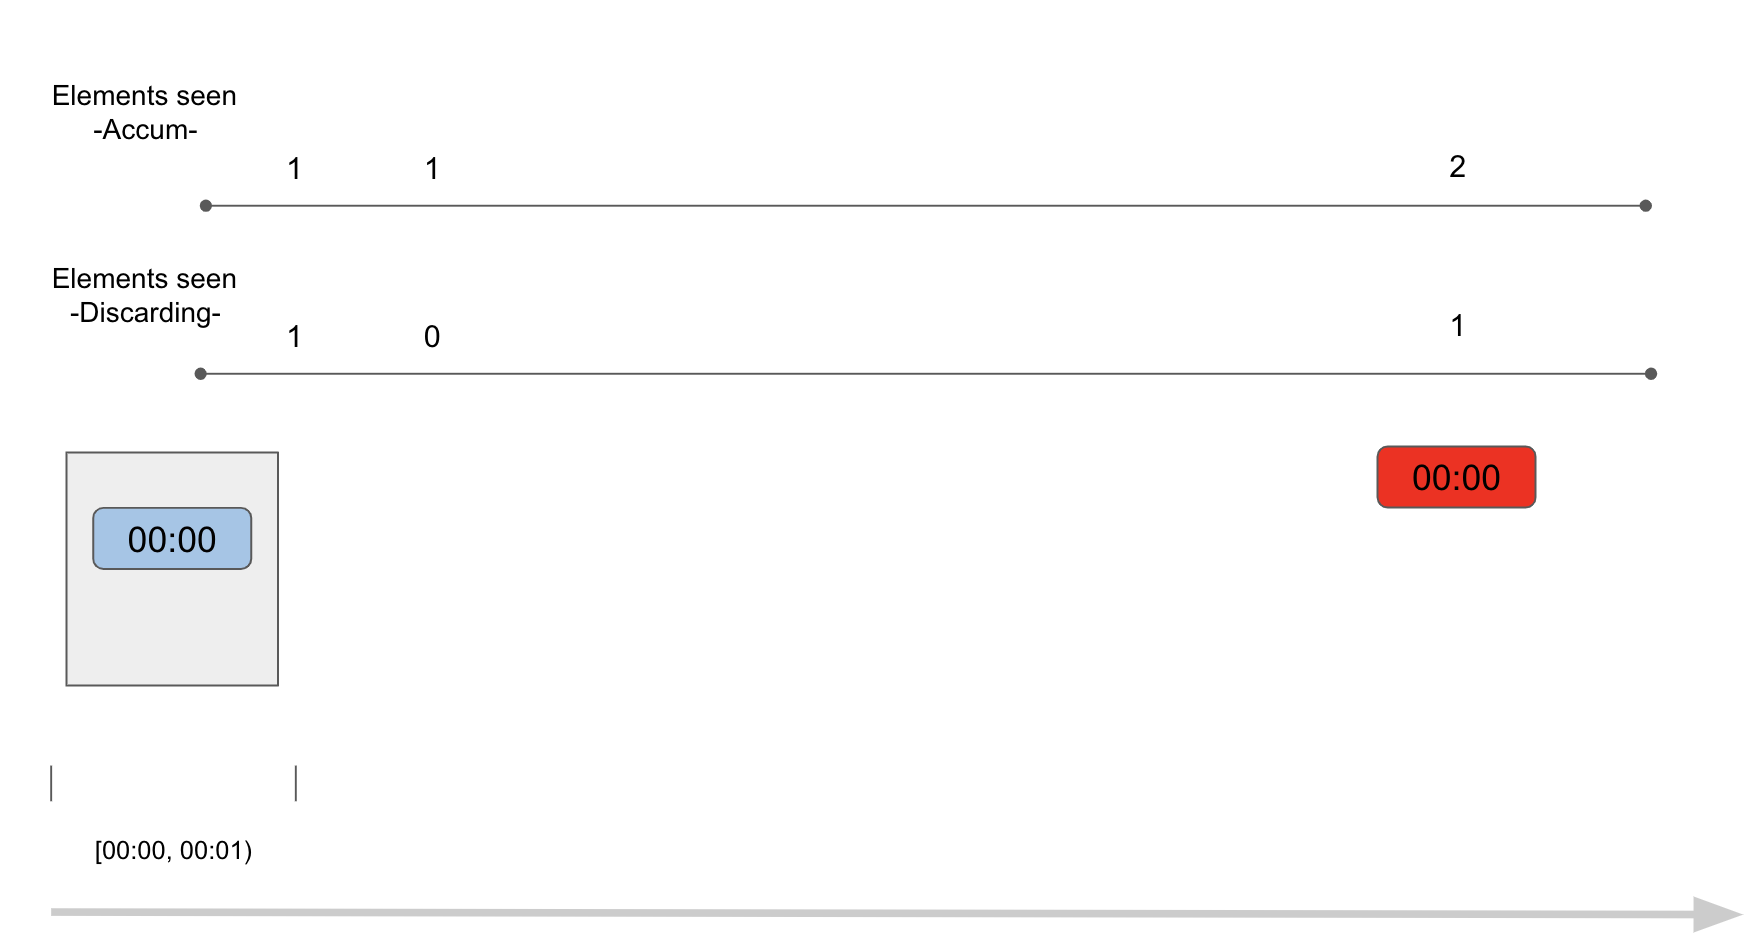

## Early results, and so we get to triggers

From the Apache Beam documentation:

*When collecting and grouping data into windows, Beam uses triggers to determine when to emit the aggregated results of each window (referred to as a pane). If you use Beam’s default windowing configuration and default trigger, Beam outputs the aggregated result when it estimates all data has arrived, and discards all subsequent data for that window.*



### Early results
Triggers allow Beam to emit early results, before all the data in a given window has arrived. For example, emitting after a certain amount of time elapses, or after a certain number of elements have arrived.

As we look to explore triggers we will expand our window size to 5 to include more than a few elements in each window. 

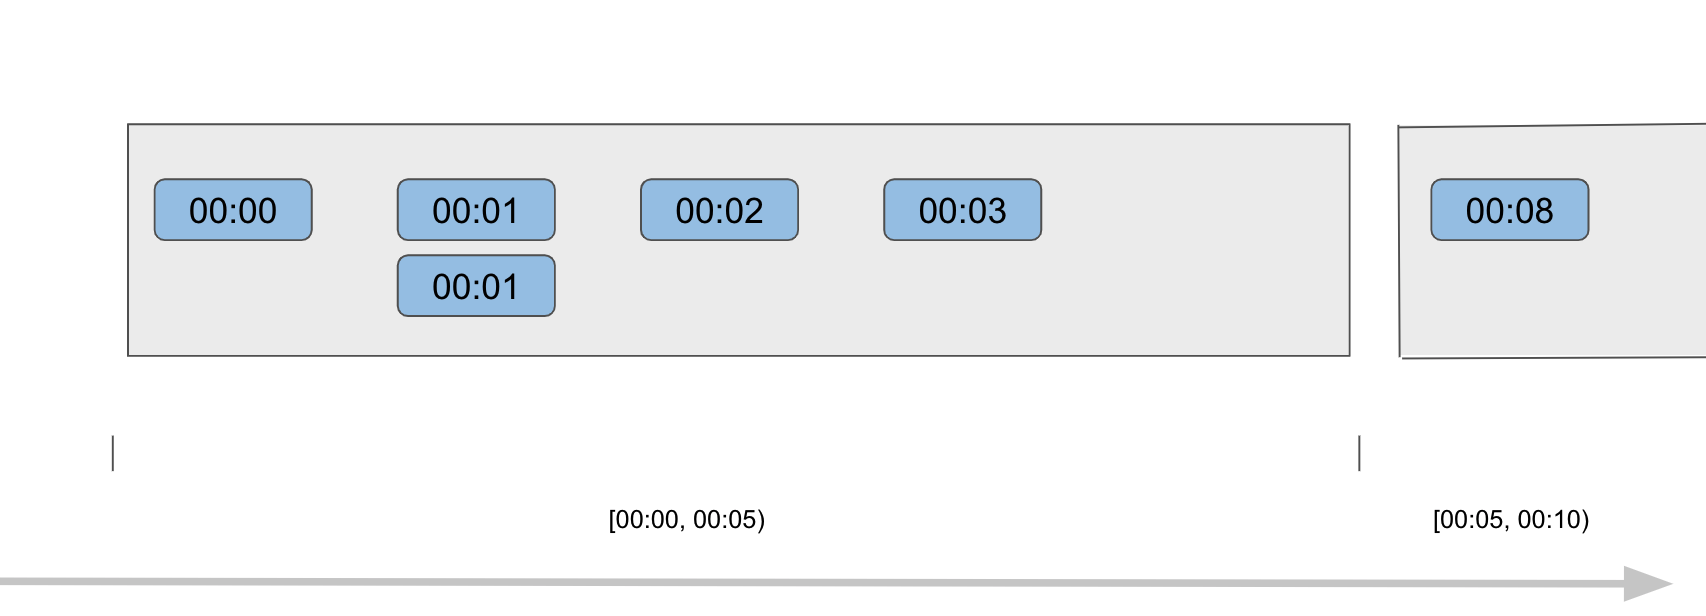

We will start with a trigger which closely matches the default trigger, which we have been using until now.

In [ ]:
  options = StandardOptions(streaming=True)

  with TestPipeline(options=options) as p:
    _ = (p | create_late_data_stream() 
        | beam.Map(lambda x : x) # Work around for typing issue
        | beam.WindowInto(beam.window.FixedWindows(5), # <- We change the window to 5 sec fixed windows 
                                trigger=beam.trigger.AfterWatermark(),
                                accumulation_mode=beam.trigger.AccumulationMode.ACCUMULATING, 
                                allowed_lateness=0) # <-- We have reset allowed lateness to 0
        | beam.combiners.Count.PerKey()
        | beam.Map(lambda x : f'Count is {x[1]}')
        | "Output Window" >> beam.ParDo(GetElementTimestamp(print_pane_info=True))
        | "Print count" >> PrettyPrint()
  )

('Window ends at 2000-01-01 10:00:04.999999', 'The value : Count is 5 has timestamp 2000-01-01 10:00:04.999999 with Pane PaneInfo(first: True, last: True, timing: ON_TIME, index: 0, nonspeculative_index: 0)')
('Window ends at 2000-01-01 10:00:09.999999', 'The value : Count is 1 has timestamp 2000-01-01 10:00:09.999999 with Pane PaneInfo(first: True, last: True, timing: ON_TIME, index: 0, nonspeculative_index: 0)')


| Window - Start | Window - End | Value | Pane - First | Pane - Last | Pane - Timing
| :---:  |  :---:  | :---:  | :---:  | :---:  | :---:  |
| 10:00:00 | 10:00:04.999999 | 5 | True | True | ON_TIME
| 10:00:05 | 10:00:09.999999 | 1 | True | True | ON_TIME

**Event time triggers**

The `Afterwatermark` trigger is an example of an *Event time trigger* which operate in event time, as indicated by the timestamp on each data element. It will fire exactly once when the watermark passes the end of the window. The trigger used in the above cell, is the same as the default trigger. 

**Other triggers**

But now that we have larger windows, what if we wanted to see early speculative results? For example what if we wanted to see an estimate of the count before we reach the watermark? 

For this we will have multiple options, we can either make use of a processing time trigger or a data driven trigger.



***Data-driven triggers*** 

*These triggers operate by examining the data as it arrives in each window, and firing when that data meets a certain property. Currently, data-driven triggers only support firing after a certain number of data elements. In the cell below we make use of the `AfterCount` trigger. This trigger works on  element counts; it fires after the current pane has collected at least N elements. This allows a window to emit early results (before all the data has accumulated), which can be particularly useful if you are using a single global window.*

This trigger however would only fire once, if we was to use it as the only trigger. To get the effect that we are looking for we need to create a ***CompositeTrigger***. There are several ways that we can do this, but for now we will make use of the easiest path which is to use the `early` parameter with `AfterWatermark` which is a utility that builds a composite trigger for us. The trigger will fire a pane when either the watermark is reached, or we have 3 or more elements in the window.

In [ ]:
  options = StandardOptions(streaming=True)
  
  with TestPipeline(options=options) as p:
    _ = (p | create_late_data_stream() 
        | beam.Map(lambda x : x) # Work around for typing issue
        | beam.WindowInto(beam.window.FixedWindows(5), # <- We change the window to 5 sec fixed windows 
                          trigger=beam.trigger.AfterWatermark(early=beam.trigger.AfterCount(3)),
                          accumulation_mode=beam.trigger.AccumulationMode.ACCUMULATING, # We discard the information 
                          allowed_lateness=0) 
        | beam.combiners.Count.PerKey()
        | beam.Map(lambda x : f'Count is {x[1]}')
        | "Output Window" >> beam.ParDo(GetElementTimestamp(print_pane_info=True))
        | "Print count" >> PrettyPrint()
  )

('Window ends at 2000-01-01 10:00:04.999999', 'The value : Count is 3 has timestamp 2000-01-01 10:00:04.999999 with Pane PaneInfo(first: True, last: False, timing: EARLY, index: 0, nonspeculative_index: -1)')
('Window ends at 2000-01-01 10:00:04.999999', 'The value : Count is 5 has timestamp 2000-01-01 10:00:04.999999 with Pane PaneInfo(first: False, last: True, timing: ON_TIME, index: 1, nonspeculative_index: 0)')
('Window ends at 2000-01-01 10:00:09.999999', 'The value : Count is 1 has timestamp 2000-01-01 10:00:09.999999 with Pane PaneInfo(first: True, last: True, timing: ON_TIME, index: 0, nonspeculative_index: 0)')


| Window - Start | Window - End | Value | Pane - First | Pane - Last | Pane - Timing
| :---:  |  :---:  | :---:  | :---:  | :---:  | :---:  |
| 10:00:00 | 10:00:04.999999 | 3 | True | False | EARLY
| 10:00:00 | 10:00:04.999999 | 5 | False | True | ON_TIME
| 10:00:09 | 10:00:09.999999 | 1 | True | True | ON_TIME




**NOTE** AfterCount will be based on ***at least*** so you may get different results, the actual number output will be nondeterministic.

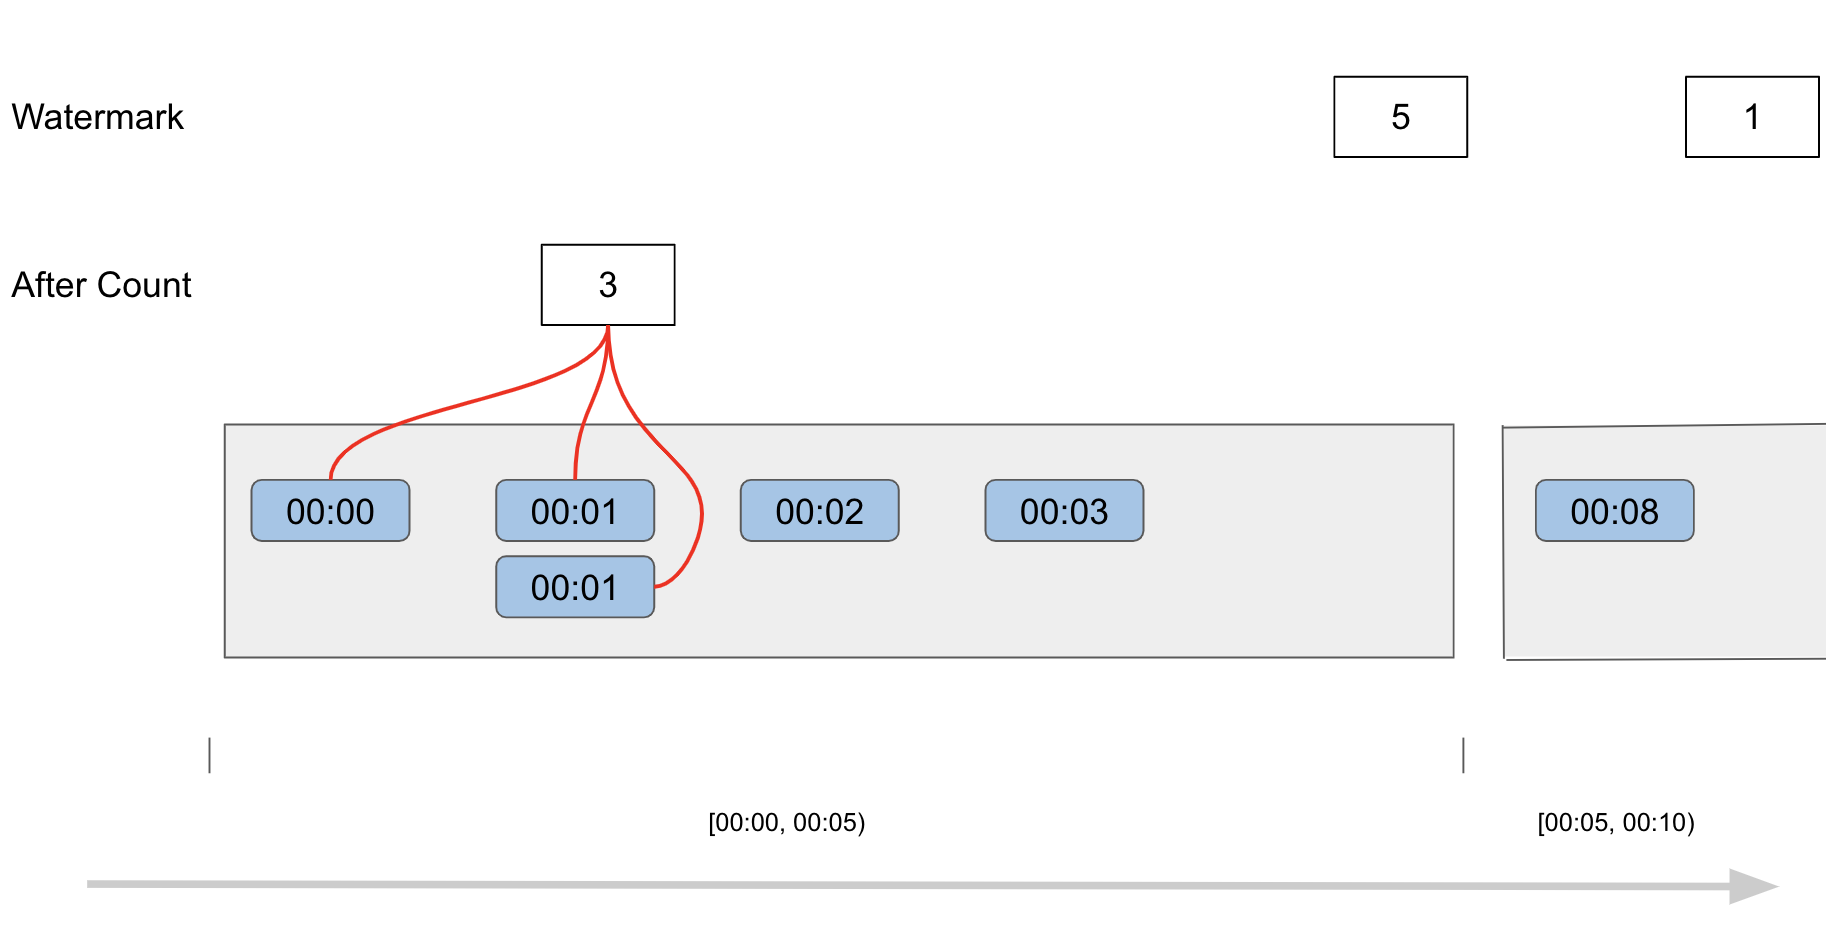

***Processing time triggers*** 

These triggers operate on the processing time – the time when the data element is processed at any given stage in the pipeline.

In the cell below we will make use of a composite trigger, which makes use of processing time and `AfterCount` to create a trigger which will output values every 1 sec or when there are 2 data elements in the window. 

There are also two other trigger primitves used by the composite trigger, `Repeatedly` and `AfterAny`. 

***Repeatedly***
A Trigger that fires according to its subtrigger forever.

***AfterAny***
Fires when any subtrigger fires.
Also finishes when any subtrigger finishes.



In [ ]:
## Processing time not working with TestStream
options = StandardOptions(streaming=True)

with TestPipeline(options=options) as p:
  _ = (p | create_late_data_stream() 
      | beam.Map(lambda x : x) # Work around for typing issue
            | beam.WindowInto(beam.window.FixedWindows(5), # <- We change the window to 5 sec fixed windows 
                              trigger=beam.trigger.AfterWatermark(early=beam.trigger.AfterAny(beam.trigger.AfterCount(2), beam.trigger.AfterProcessingTime(1))),
                              accumulation_mode=beam.trigger.AccumulationMode.ACCUMULATING, 
                              allowed_lateness=0) 
      | beam.combiners.Count.PerKey()
      | beam.Map(lambda x : f'Count is {x[1]}')
      | "Output Window" >> beam.ParDo(GetElementTimestamp(print_pane_info=True))
      | "Print count" >> PrettyPrint()
)

('Window ends at 2000-01-01 10:00:04.999999', 'The value : Count is 1 has timestamp 2000-01-01 10:00:04.999999 with Pane PaneInfo(first: True, last: False, timing: EARLY, index: 0, nonspeculative_index: -1)')
('Window ends at 2000-01-01 10:00:04.999999', 'The value : Count is 2 has timestamp 2000-01-01 10:00:04.999999 with Pane PaneInfo(first: False, last: False, timing: EARLY, index: 1, nonspeculative_index: -1)')
('Window ends at 2000-01-01 10:00:04.999999', 'The value : Count is 1 has timestamp 2000-01-01 10:00:04.999999 with Pane PaneInfo(first: True, last: False, timing: EARLY, index: 0, nonspeculative_index: -1)')
('Window ends at 2000-01-01 10:00:04.999999', 'The value : Count is 2 has timestamp 2000-01-01 10:00:04.999999 with Pane PaneInfo(first: False, last: False, timing: EARLY, index: 1, nonspeculative_index: -1)')
('Window ends at 2000-01-01 10:00:09.999999', 'The value : Count is 1 has timestamp 2000-01-01 10:00:09.999999 with Pane PaneInfo(first: True, last: True, timing:

***NOTE*** 

Processing time here is not firing correctly with the TestStream class. tbd raise Jira issue. The values will work correctly when used with a standard unbounded source.

| Window - Start | Window - End | Value | Pane - First | Pane - Last | Pane - Timing
| :---:  |  :---:  | :---:  | :---:  | :---:  | :---:  |
| 10:00:00 | 10:00:04.999999 | 1 | True | False | EARLY
| 10:00:00 | 10:00:04.999999 | 2 | False | False | EARLY
| 10:00:00 | 10:00:04.999999 | 1 | True | False | EARLY
| 10:00:00 | 10:00:04.999999 | 2 | False | False | EARLY
| 10:00:09 | 10:00:09.999999 | 1 | True | True | ON_TIME


### Use cases for triggers

**Completeness**: 

How important is it to have all of your data before you compute your result?

**Latency**: 

How long do you want to wait for data? For example, do you wait until you think you have all data? Do you process data as it arrives?

**Cost**: 

How much compute power/money are you willing to spend to lower the latency?


# MERGING WINDOWS



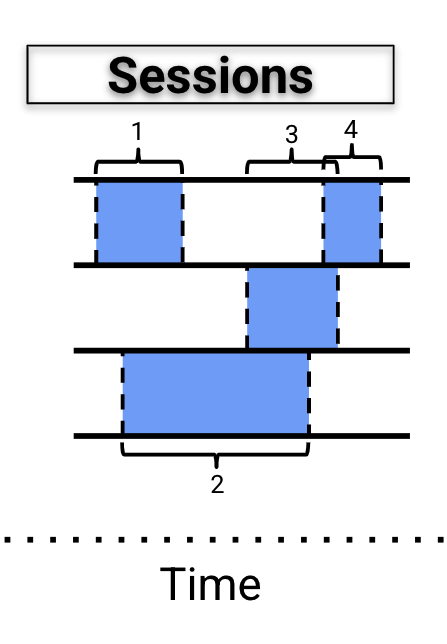

In the example below we make use of some test clickstream data which has events coming from an application. The session window has been set to create a session when there is no user activity for 9 secs. In our TestStream we have a 9 sec gap between events, which will result in two sessions being output by the window. 


In [ ]:
format = '%Y/%m/%d %H:%M:%S'
start = time.mktime(time.strptime('2000/01/01 10:00:00', format))

test_stream = TestStream()
test_stream.advance_watermark_to(start)
test_stream.advance_processing_time(start)

# lets add the values
test_stream.add_elements([beam.window.TimestampedValue(('id-1', 'Browse', 1000), start+1)])
test_stream.advance_watermark_to(start+1)
test_stream.advance_processing_time(start+1)
test_stream.add_elements([beam.window.TimestampedValue(('id-1','Browse', 1005), start+2)])
test_stream.advance_watermark_to(start+2)
test_stream.advance_processing_time(start+2)
test_stream.add_elements([beam.window.TimestampedValue(('id-1','Purchase', 1005 ), start+3)])
test_stream.advance_watermark_to(start+12)
test_stream.advance_processing_time(start+12)
test_stream.add_elements([beam.window.TimestampedValue(('id-1','admin', 6000), start+13)])
test_stream.advance_watermark_to(start+14)
test_stream.advance_processing_time(start+14)
test_stream.add_elements([beam.window.TimestampedValue(('id-1','admin', 8000), start+14)])
test_stream.advance_watermark_to(start+15)
test_stream.advance_processing_time(start+15)

test_stream.add_elements([beam.window.TimestampedValue(('id-1','Browse', 2000), start+1)]) # <-- Data arives late

test_stream.advance_watermark_to_infinity()

options = StandardOptions(streaming=True)

with TestPipeline(options=options) as p:
  _ = (p | test_stream
            | beam.Map(lambda x : (x[0],(x)))
            | beam.WindowInto(beam.window.Sessions(9), 
                              allowed_lateness=0) 
            | beam.combiners.ToList().without_defaults()
            | "Output Window" >> beam.ParDo(GetElementTimestamp(print_pane_info=True))
            | "Print count" >> beam.Map(print)
  )


('Window ends at 2000-01-01 10:00:11.999999', "The value : [('id-1', ('id-1', 'Browse', 1000)), ('id-1', ('id-1', 'Browse', 1005)), ('id-1', ('id-1', 'Purchase', 1005))] has timestamp 2000-01-01 10:00:11.999999 with Pane PaneInfo(first: True, last: False, timing: ON_TIME, index: 0, nonspeculative_index: 0)")
('Window ends at 2000-01-01 10:00:22.999999', "The value : [('id-1', ('id-1', 'admin', 6000)), ('id-1', ('id-1', 'admin', 8000))] has timestamp 2000-01-01 10:00:22.999999 with Pane PaneInfo(first: True, last: False, timing: ON_TIME, index: 0, nonspeculative_index: 0)")
